In [1]:
from sentence_transformers import SentenceTransformer
import random
import nltk
import dspy
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import pipeline
import re
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import ndcg_score
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import matplotlib.cm as cm
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from sklearn.metrics import ndcg_score
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib
import os
import random
from sklearn.preprocessing import normalize
import colorcet as cc

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def create_category_string(category, dictionary, n=None):
    string = f"{category}: "

    if category in dictionary:
        category_data = dictionary[category]
        if isinstance(category_data, list):
            if category == 'characters' and n is not None:
                category_data = category_data[:n]
            for item in category_data:
                for k, v in item.items():
                    if k == 'name':
                        continue
                    if isinstance(v, list):
                        v = ', '.join(v)
                    string += f"{k}: {v} "
        elif isinstance(category_data, dict):
            for k, v in category_data.items():
                if k == 'name':
                    continue
                if isinstance(v, list):
                    v = ', '.join(v)
                string += f"{k}: {v} "
        else:
            string += f"{category}: {category_data} "

    return string.strip()

def transform_dict_to_strings(data, n=None):
    result = {}

    for category in data:
        result[category] = create_category_string(category, data, n=n)

    return result

def transform_dict_to_single_string(data, n=None):
    parts = []

    for category in data:
        parts.append(create_category_string(category, data, n=n))

    return " ".join(parts).strip()


In [3]:
class CharacterAnonymizer:
    def __init__(self, batch_size=16):
        self.ner_pipeline = pipeline(
            "ner",
            model="Jean-Baptiste/roberta-large-ner-english",
            aggregation_strategy="simple",
            device=0
        )
        self.batch_size = batch_size

    def normalize_name(self, name):
        name = name.lower()
        name = re.sub(r"[^a-z ]", "", name)
        return name.strip()

    def extract_names_batch(self, texts):
        ner_results_batch = self.ner_pipeline(texts)
        all_names = []
        for ner_results in ner_results_batch:
            names = [ent['word'] for ent in ner_results if ent['entity_group'] == 'PER']
            normalized = list(set(self.normalize_name(name) for name in names))
            all_names.append(normalized)
        return all_names

    def cluster_names(self, names):
        clusters = defaultdict(list)
        used = set()

        for name in names:
            if not name.strip():
                continue
            if name in used:
                continue
            parts = name.split()
            if not parts:
                continue
            key = parts[0]
            for other in names:
                if key in other and other not in used:
                    clusters[key].append(other)
                    used.add(other)
        return clusters

    def generate_name_map(self, clusters):
        name_map = {}
        for i, (key, variants) in enumerate(clusters.items(), start=1):
            tag = f"Character{i}"
            for name in variants:
                name_map[name] = tag
        return name_map

    def replace_names(self, text, name_map):
        for original in sorted(name_map.keys(), key=len, reverse=True):
            pattern = re.compile(rf'\b{re.escape(original)}\b', re.IGNORECASE)
            text = pattern.sub(name_map[original], text)
        return text

    def anonymize_batch(self, texts):
        anonymized_texts = []

        for i in tqdm(range(0, len(texts), self.batch_size), desc="Anonymizing"):
            batch = texts[i:i + self.batch_size]
            all_names = self.extract_names_batch(batch)

            for text, names in zip(batch, all_names):
                clusters = self.cluster_names(names)
                name_map = self.generate_name_map(clusters)
                anonymized = self.replace_names(text, name_map)
                anonymized_texts.append(anonymized)

        return anonymized_texts


In [4]:
def build_index(embeddings, normalize_vectors=True):
    if normalize_vectors:
        return normalize(embeddings, axis=1)
    return embeddings


def get_dense_similarity(query_vector, candidate_vectors):
    if query_vector.ndim == 1:
        query_vector = query_vector.reshape(1, -1)
    return np.dot(candidate_vectors, query_vector.T).flatten()

def get_relevance_scores(i, labels, index):
    matching_label = labels[i]

    query_vector = index[i].reshape(1, -1)
    similarities = get_dense_similarity(query_vector, index).flatten()

    relevance_scores = np.array([1 if x == matching_label else 0 for x in labels])
    similarity_scores = similarities

    mask = np.arange(len(labels)) != i

    relevance_scores = relevance_scores[mask]
    similarity_scores = similarity_scores[mask]

    return relevance_scores.tolist(), similarity_scores.tolist()


def calculate_mean_ndcg_score(labels, embeddings):
    embeddings = np.array(embeddings).astype('float32')
    index = build_index(embeddings)

    scores = []

    for i in range(len(labels)):
        relevance_scores, similarity_scores = get_relevance_scores(i, labels, index)
        relevance_scores = np.array(relevance_scores)
        similarity_scores = np.array(similarity_scores)
        #k = relevance_scores.sum()
        k = None
        scores.append(ndcg_score([relevance_scores], [similarity_scores], k=k))

    return np.mean(scores)


def calculate_mean_recall(labels, embeddings):
    embeddings = np.array(embeddings).astype('float32')
    index = build_index(embeddings)

    recalls = []

    for i in range(len(labels)):
        relevance_scores, similarity_scores = get_relevance_scores(i, labels, index)

        relevance_scores = np.array(relevance_scores)
        similarity_scores = np.array(similarity_scores)

        k = relevance_scores.sum()
        if k == 0:
            continue

        sorted_indices = np.argsort(-similarity_scores)

        top_k_indices = sorted_indices[:k]

        top_k_relevance = relevance_scores[top_k_indices]

        recall = top_k_relevance.sum() / k
        recalls.append(recall)

    if len(recalls) == 0:
        return 0.0
    return np.mean(recalls)





In [5]:
def min_max_scale(arr):
    arr = np.array(arr)
    min_val = arr.min()
    max_val = arr.max()
    if max_val == min_val:
        return np.zeros_like(arr)
    return (arr - min_val) / (max_val - min_val)


def get_dense_similarity(query_vec, matrix):
    query_vec = np.array(query_vec).reshape(1, -1)
    return cosine_similarity(query_vec, matrix)[0]



#def transform_dict_to_strings(d):
    #return {k: ' '.join(str(vv) for vv in v) if isinstance(v, list) else str(v) for k, v in d.items()}


def get_similarity_scores_from_embeddings(df, index, keys):
    keys.append("overall")
    similarities_by_key = {}

    for key in keys:
        embeddings = np.stack(df[f'embedding_{key}'].values)
        target_embedding = embeddings[index]
        similarities = get_dense_similarity(target_embedding, embeddings)
        similarities_by_key[key] = min_max_scale(similarities)

    all_similarities = np.zeros_like(next(iter(similarities_by_key.values())))

    return similarities_by_key


def make_spider(df, plot_idx, title, color, total_plots, overall_score, plots_per_row=5):
    categories = list(df.columns)[1:]
    if 'overall' in categories:
        categories.remove('overall')
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    row_idx = plot_idx // plots_per_row
    col_idx = plot_idx % plots_per_row
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row
    n_cols = min(plots_per_row, total_plots)

    ax = plt.subplot(n_rows, n_cols, plot_idx + 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='black', size=10)
    ax.set_rlabel_position(0)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ["0", "0.2", "0.4", "0.6", "0.8", "1"], color="grey", size=7)
    plt.ylim(0, 1)

    values = df.loc[plot_idx, categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    wrapped_title = "\n".join(title[i:i + 20] for i in range(0, len(title), 20))
    plt.title(wrapped_title, size=18, color=color, y=1.08)

    ax.text(0.5, 0.5, f"{overall_score:.2f}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center',
            fontsize=24, fontweight='bold', color=color)


def visualize_similarities(df, model, target_index, top_n=4, plots_per_row=5, ascending=False, exclude_self=False, exclude_keys=None):
    embedding_cols = [col for col in df.columns if col.startswith("embedding_")]

    if exclude_keys is None:
        exclude_keys = []

    if not embedding_cols:
        df, keys = embed_elements(df, model)
    else:
        keys = [col.replace("embedding_", "") for col in embedding_cols 
                if col.replace("embedding_", "") not in exclude_keys and col != "embedding_overall"]

    similarities_by_key = get_similarity_scores_from_embeddings(df, index=target_index, keys=keys)

    overall_similarities = similarities_by_key["overall"]

    sorted_indices = np.argsort(overall_similarities)
    if not ascending:
        sorted_indices = sorted_indices[::-1]

    title_to_exclude = df.iloc[target_index]["title"] if exclude_self else None

    filtered_indices = []
    for i in sorted_indices:
        if exclude_self and df.iloc[i]["title"] == title_to_exclude:
            continue
        if not exclude_self and i == target_index:
            continue 
        filtered_indices.append(i)
        if len(filtered_indices) == top_n:
            break

    rows = []
    for i in filtered_indices:
        title = f"{df.iloc[i]['title']} ({df.iloc[i]['language']})"
        data_row = {'group': title}
        for key in keys:
            data_row[key] = similarities_by_key[key][i]
        data_row['overall'] = overall_similarities[i]
        rows.append(data_row)

    query_title = f"{df.iloc[target_index]['title']} ({df.iloc[target_index]['language']})"
    query_row = {'group': f"Query: {query_title}"}
    for key in keys:
        query_row[key] = similarities_by_key[key][target_index]
    query_row['overall'] = overall_similarities[target_index]
    rows.insert(0, query_row)

    plot_data = pd.DataFrame(rows)

    my_dpi = 96
    width_per_plot = 500
    height_per_plot = 500
    total_plots = len(plot_data.index)
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row

    fig_width = width_per_plot * min(plots_per_row, total_plots) / my_dpi
    fig_height = height_per_plot * n_rows / my_dpi

    plt.figure(figsize=(fig_width, fig_height), dpi=my_dpi)
    base_titles = plot_data['group'].apply(lambda x: x.replace('Query: ', '').split(' (')[0])
    unique_titles = base_titles.unique()
    title_to_color_idx = {title: i for i, title in enumerate(unique_titles)}

    my_palette = cc.glasbey_dark  

    for plot_idx in range(total_plots):
        base_title = base_titles.iloc[plot_idx]
        color_idx = title_to_color_idx[base_title]
        color = my_palette[color_idx]  
    
        make_spider(df=plot_data, plot_idx=plot_idx, title=plot_data['group'][plot_idx],
                    color=color, total_plots=total_plots,
                    overall_score=plot_data.loc[plot_idx, 'overall'],
                    plots_per_row=plots_per_row)
    
    plt.tight_layout()
    plt.savefig("similarity_radar_plots.png", dpi=my_dpi, bbox_inches='tight')
    plt.show()


In [6]:
def embed_elements(df, model):
    transformed_data = []
    key_set = set()

    for row in df.itertuples(index=False):
        element = json.loads(row.extracted_elements)
        element['full_summary'] = row.unpacked_summary # add a full summary embedding
        transformed = transform_dict_to_strings(element, n=5)
        transformed_data.append(transformed)
        key_set.update(transformed)

    transformed_df = pd.DataFrame(transformed_data)

    embedding_arrays = {}
    for key in key_set:
        texts = transformed_df[key].tolist()
        embeddings = model.encode(texts, show_progress_bar=False)
        normalized_embeddings = normalize(np.array(embeddings), norm='l2')
        df[f'embedding_{key}'] = list(normalized_embeddings)
        embedding_arrays[key] = normalized_embeddings

    all_embeddings = np.stack([embedding_arrays[key] for key in key_set], axis=1)
    mean_embeddings = np.mean(all_embeddings, axis=1)
    df["embedding_overall"] = list(normalize(mean_embeddings, norm='l2'))

    return df, list(key_set)


In [7]:
class SimpleAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=64, print_weights = False):
        super().__init__()
        self.weights = []
        self.print_weights = print_weights
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, embeddings):
        scores = self.attention(embeddings)  
        weights = torch.softmax(scores, dim=0) 
        if self.print_weights:
            self.weights.append(weights)
            print(torch.stack(self.weights).mean(dim=0))
        return (weights * embeddings).sum(dim=0) 


In [8]:
class StaticWeightedCombiner(nn.Module):
    def __init__(self, num_embeddings):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(num_embeddings)) 

    def forward(self, embeddings): 
        weights = torch.softmax(self.weights, dim=0)  
        return (weights.unsqueeze(-1) * embeddings).sum(dim=0) 


In [9]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, df, embedding_cols, labels):
        self.embedding_data = df[embedding_cols].values
        self.labels = labels

    def __len__(self):
        return len(self.embedding_data)

    def __getitem__(self, idx):
        embeddings = [torch.tensor(e, dtype=torch.float32) for e in self.embedding_data[idx]]
        label = self.labels[idx]
        return torch.stack(embeddings), label


In [10]:
def train_attention(df, embedding_cols, labels, eval_df, eval_labels,
                    epochs=10, batch_size=32, learning_rate=1e-3, margin=1.0):
    
    attention_model = SimpleAttention(len(df[embedding_cols[0]][0]))
    #attention_model = StaticWeightedCombiner(num_embeddings = 6)
    optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)
    criterion = nn.TripletMarginLoss(margin=margin)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    dataset = EmbeddingDataset(df, embedding_cols, encoded_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        attention_model.train()
        total_loss = 0
        for batch in dataloader:
            embeddings_batch, labels_batch = batch
            anchor_embs, positive_embs, negative_embs = [], [], []

            for i in range(len(labels_batch)):
                anchor = embeddings_batch[i]
                label = labels_batch[i]

                pos_indices = (labels_batch == label).nonzero(as_tuple=True)[0]
                neg_indices = (labels_batch != label).nonzero(as_tuple=True)[0]

                if len(pos_indices) <= 1 or len(neg_indices) == 0:
                    continue

                pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                while pos_idx == i:
                    pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                anchor_embs.append(attention_model(anchor))
                positive_embs.append(attention_model(embeddings_batch[pos_idx]))
                negative_embs.append(attention_model(embeddings_batch[neg_idx]))

            if anchor_embs:
                anchor_embs = torch.stack(anchor_embs)
                positive_embs = torch.stack(positive_embs)
                negative_embs = torch.stack(negative_embs)

                loss = criterion(anchor_embs, positive_embs, negative_embs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        avg_eval_loss = evaluate_attention(attention_model, eval_df, embedding_cols, eval_labels,
                                           batch_size=batch_size, margin=margin)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f} | Eval Loss = {avg_eval_loss:.4f}")

    return attention_model


In [11]:
def evaluate_attention(model, df, embedding_cols, labels, batch_size=32, margin=1.0):
    model.eval()
    criterion = nn.TripletMarginLoss(margin=margin)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    dataset = EmbeddingDataset(df, embedding_cols, encoded_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch in dataloader:
            embeddings_batch, labels_batch = batch
            anchor_embs, positive_embs, negative_embs = [], [], []

            for i in range(len(labels_batch)):
                anchor = embeddings_batch[i]
                label = labels_batch[i]

                pos_indices = (labels_batch == label).nonzero(as_tuple=True)[0]
                neg_indices = (labels_batch != label).nonzero(as_tuple=True)[0]

                if len(pos_indices) <= 1 or len(neg_indices) == 0:
                    continue

                pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                while pos_idx == i:
                    pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                anchor_embs.append(model(anchor))
                positive_embs.append(model(embeddings_batch[pos_idx]))
                negative_embs.append(model(embeddings_batch[neg_idx]))

            if anchor_embs:
                anchor_embs = torch.stack(anchor_embs)
                positive_embs = torch.stack(positive_embs)
                negative_embs = torch.stack(negative_embs)

                loss = criterion(anchor_embs, positive_embs, negative_embs)
                total_loss += loss.item()
                count += 1

    return total_loss / max(count, 1)


In [12]:
def apply_attention(df, embedding_cols, model):
    df["embedding_overall"] = df[embedding_cols].apply(
        lambda row: model(
            torch.stack([torch.tensor(x, dtype=torch.float32) for x in row])
        ).detach().numpy(),
        axis=1
    )
    return df


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device=device)
embedder = dspy.Embedder(model.encode)
df = pd.read_excel("data/tell_me_again_df_with_elements_v6.xlsx")
df = df.dropna()

<All keys matched successfully>


In [14]:
set_seed(42)
unique_labels = df['label'].unique()


train_labels, val_labels = train_test_split(
    unique_labels,
    test_size=0.4,
    random_state=42
)

In [15]:
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]

if not embedding_cols:
    df, key_set = embed_elements(df, model)
    
df_train = df[df['label'].isin(train_labels)].reset_index(drop=True)
df_val = df[df['label'].isin(val_labels)].reset_index(drop=True)

In [16]:
embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]#"embedding_full_summary"

In [17]:
embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]#"embedding_full_summary"

In [39]:
# Train attention model on training set

attention_model =train_attention(df_train, embedding_cols, df_train.label.tolist(), df_val, df_val.label.tolist(),
                    epochs=100, batch_size=128, learning_rate=0.0001, margin=0.1)
# Apply model on validation set
df_val = apply_attention(df_val, embedding_cols, attention_model)

# Evaluate
score = calculate_mean_ndcg_score(
    labels=df_val.label.tolist(),
    embeddings=df_val.embedding_overall.tolist()
)

recall_score = calculate_mean_recall(
    labels=df_val.label.tolist(),
    embeddings=df_val.embedding_overall.tolist()
)
print(f"Validation NDCG: {score}\nValidation Recall: {recall_score}")

Epoch 1: Train Loss = 0.0074 | Eval Loss = 0.0020
Epoch 2: Train Loss = 0.0089 | Eval Loss = 0.0025
Epoch 3: Train Loss = 0.0079 | Eval Loss = 0.0019
Epoch 4: Train Loss = 0.0086 | Eval Loss = 0.0023
Epoch 5: Train Loss = 0.0057 | Eval Loss = 0.0019
Epoch 6: Train Loss = 0.0061 | Eval Loss = 0.0020
Epoch 7: Train Loss = 0.0053 | Eval Loss = 0.0021
Epoch 8: Train Loss = 0.0061 | Eval Loss = 0.0018
Epoch 9: Train Loss = 0.0090 | Eval Loss = 0.0013
Epoch 10: Train Loss = 0.0085 | Eval Loss = 0.0010
Epoch 11: Train Loss = 0.0104 | Eval Loss = 0.0009
Epoch 12: Train Loss = 0.0074 | Eval Loss = 0.0009
Epoch 13: Train Loss = 0.0075 | Eval Loss = 0.0007
Epoch 14: Train Loss = 0.0074 | Eval Loss = 0.0007
Epoch 15: Train Loss = 0.0075 | Eval Loss = 0.0009
Epoch 16: Train Loss = 0.0094 | Eval Loss = 0.0010
Epoch 17: Train Loss = 0.0090 | Eval Loss = 0.0006
Epoch 18: Train Loss = 0.0070 | Eval Loss = 0.0006
Epoch 19: Train Loss = 0.0093 | Eval Loss = 0.0003
Epoch 20: Train Loss = 0.0035 | Eval Los

In [ ]:
#model = SentenceTransformer('all-MiniLM-L6-v2')
#texts = df['unpacked_summary'].tolist()
#embs = model.encode(texts, batch_size=15, show_progress_bar=True)
#df["embedding_overall"] = list(embs)

In [118]:
#anonymizer = CharacterAnonymizer(batch_size=16)
#df['anonymized_elements'] = anonymizer.anonymize_batch(df['extracted_elements'].tolist())

Device set to use cuda:0
Anonymizing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [03:21<00:00,  1.26it/s]


In [119]:
#df['extracted_elements'] = df['anonymized_elements']

In [94]:
#lst = [transform_dict_to_single_string(json.loads(x)) for x in df['extracted_elements'].tolist()]

In [105]:
#embs = model.encode(df['unpacked_summary'].tolist(), batch_size=15, show_progress_bar = True)

Batches:   0%|          | 0/272 [00:00<?, ?it/s]

In [106]:
#df['embedding_overall'] = list(embs)

In [19]:
from sklearn.model_selection import GroupKFold
import numpy as np

set_seed(42)
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]

if not embedding_cols:
    df, key_set = embed_elements(df, model)

labels = df['label'].tolist()
groups = df['label']
n_splits = 5

gkf = GroupKFold(n_splits=n_splits)

ndcg_scores = []
recall_scores = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(df, labels, groups=groups)):
    print(f"\n--- Fold {fold+1} ---")
    
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_val = df.iloc[val_idx].reset_index(drop=True)

    embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]#

    attention_model = train_attention(
        df_train, embedding_cols, df_train.label.tolist(),
       df_val, df_val.label.tolist(),
        #
        epochs=100, batch_size=128, learning_rate=0.0001, margin=0.1
    )

    df_val = apply_attention(df_val, embedding_cols, attention_model)

    ndcg = calculate_mean_ndcg_score(
        labels=df_val.label.tolist(),
        embeddings=df_val.embedding_overall.tolist()
    )
    recall = calculate_mean_recall(
        labels=df_val.label.tolist(),
        embeddings=df_val.embedding_overall.tolist()
    )

    ndcg_scores.append(ndcg)
    recall_scores.append(recall)

    print(f"Fold {fold+1} NDCG: {ndcg}\nFold {fold+1} Recall: {recall}")

# Summary
print("\n=== Cross-Validation Summary ===")
print(f"Average NDCG: {np.mean(ndcg_scores):.4f} ± {np.std(ndcg_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")



--- Fold 1 ---
Epoch 1: Train Loss = 0.0070 | Eval Loss = 0.0016
Epoch 2: Train Loss = 0.0054 | Eval Loss = 0.0018
Epoch 3: Train Loss = 0.0060 | Eval Loss = 0.0017
Epoch 4: Train Loss = 0.0066 | Eval Loss = 0.0018
Epoch 5: Train Loss = 0.0085 | Eval Loss = 0.0015
Epoch 6: Train Loss = 0.0053 | Eval Loss = 0.0017
Epoch 7: Train Loss = 0.0075 | Eval Loss = 0.0017
Epoch 8: Train Loss = 0.0084 | Eval Loss = 0.0018
Epoch 9: Train Loss = 0.0059 | Eval Loss = 0.0013
Epoch 10: Train Loss = 0.0065 | Eval Loss = 0.0012
Epoch 11: Train Loss = 0.0057 | Eval Loss = 0.0012
Epoch 12: Train Loss = 0.0082 | Eval Loss = 0.0020
Epoch 13: Train Loss = 0.0067 | Eval Loss = 0.0018
Epoch 14: Train Loss = 0.0037 | Eval Loss = 0.0015
Epoch 15: Train Loss = 0.0044 | Eval Loss = 0.0016
Epoch 16: Train Loss = 0.0046 | Eval Loss = 0.0015
Epoch 17: Train Loss = 0.0075 | Eval Loss = 0.0010
Epoch 18: Train Loss = 0.0073 | Eval Loss = 0.0015
Epoch 19: Train Loss = 0.0079 | Eval Loss = 0.0009
Epoch 20: Train Loss = 0

In [41]:
from sklearn.model_selection import KFold
from itertools import product
import numpy as np

# Ensure embeddings exist
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]
if not embedding_cols:
    df, key_set = embed_elements(df, model)
embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]

# Define hyperparameter grid
param_grid = {
    'learning_rate': [1e-4, 4e-4],
    'batch_size': [128],
    'margin': [0.01,0.05, 0.1,1],
    'epochs': [50, 100, 200]
}
param_combinations = list(product(*param_grid.values()))

# Unique labels for group-wise split
unique_labels = np.array(df['label'].unique())
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for lr, bs, margin, epochs in param_combinations:
    fold_scores = []
    fold_recalls = []

    for train_idx, val_idx in kf.split(unique_labels):
        train_labels = unique_labels[train_idx]
        val_labels = unique_labels[val_idx]

        df_train = df[df['label'].isin(train_labels)].reset_index(drop=True)
        df_val = df[df['label'].isin(val_labels)].reset_index(drop=True)

        # Train model
        model = train_attention(
            df_train, embedding_cols, df_train.label.tolist(),
            df_val, df_val.label.tolist(),
            epochs=epochs, batch_size=bs, learning_rate=lr, margin=margin
        )

        # Apply model
        df_val = apply_attention(df_val, embedding_cols, model)

        # Evaluate
        ndcg = calculate_mean_ndcg_score(
            labels=df_val.label.tolist(),
            embeddings=df_val.embedding_overall.tolist()
        )
        recall = calculate_mean_recall(
            labels=df_val.label.tolist(),
            embeddings=df_val.embedding_overall.tolist()
        )

        fold_scores.append(ndcg)
        fold_recalls.append(recall)

    # Log result for this hyperparameter setting
    results.append({
        'params': {
            'learning_rate': lr,
            'batch_size': bs,
            'margin': margin,
            'epochs': epochs
        },
        'mean_ndcg': np.mean(fold_scores),
        'mean_recall': np.mean(fold_recalls)
    })

# Sort by NDCG
results = sorted(results, key=lambda x: x['mean_ndcg'], reverse=True)

# Print best result
print("Best hyperparameters:")
print(results[0])


Epoch 1: Train Loss = 0.0014 | Eval Loss = 0.0000
Epoch 2: Train Loss = 0.0004 | Eval Loss = 0.0000
Epoch 3: Train Loss = 0.0007 | Eval Loss = 0.0001
Epoch 4: Train Loss = 0.0018 | Eval Loss = 0.0000
Epoch 5: Train Loss = 0.0012 | Eval Loss = 0.0001
Epoch 6: Train Loss = 0.0012 | Eval Loss = 0.0000
Epoch 7: Train Loss = 0.0014 | Eval Loss = 0.0000
Epoch 8: Train Loss = 0.0007 | Eval Loss = 0.0000
Epoch 9: Train Loss = 0.0013 | Eval Loss = 0.0001
Epoch 10: Train Loss = 0.0020 | Eval Loss = 0.0000
Epoch 11: Train Loss = 0.0011 | Eval Loss = 0.0000
Epoch 12: Train Loss = 0.0022 | Eval Loss = 0.0001
Epoch 13: Train Loss = 0.0008 | Eval Loss = 0.0000
Epoch 14: Train Loss = 0.0016 | Eval Loss = 0.0000
Epoch 15: Train Loss = 0.0013 | Eval Loss = 0.0001
Epoch 16: Train Loss = 0.0008 | Eval Loss = 0.0000
Epoch 17: Train Loss = 0.0004 | Eval Loss = 0.0000
Epoch 18: Train Loss = 0.0014 | Eval Loss = 0.0000
Epoch 19: Train Loss = 0.0008 | Eval Loss = 0.0001
Epoch 20: Train Loss = 0.0022 | Eval Los

In [20]:
attention_model.print_weights = True

In [21]:
#df,_ = embed_elements(df, model)
df = apply_attention(df, embedding_cols, attention_model)

tensor([[0.0930],
        [0.0658],
        [0.2435],
        [0.0423],
        [0.2328],
        [0.3225]], grad_fn=<MeanBackward1>)
tensor([[0.1071],
        [0.0600],
        [0.2582],
        [0.0416],
        [0.2208],
        [0.3123]], grad_fn=<MeanBackward1>)
tensor([[0.1028],
        [0.0583],
        [0.2605],
        [0.0473],
        [0.2364],
        [0.2946]], grad_fn=<MeanBackward1>)
tensor([[0.1012],
        [0.0580],
        [0.2590],
        [0.0533],
        [0.2400],
        [0.2885]], grad_fn=<MeanBackward1>)
tensor([[0.1003],
        [0.0579],
        [0.2583],
        [0.0553],
        [0.2444],
        [0.2837]], grad_fn=<MeanBackward1>)
tensor([[0.1009],
        [0.0601],
        [0.2557],
        [0.0554],
        [0.2333],
        [0.2946]], grad_fn=<MeanBackward1>)
tensor([[0.1023],
        [0.0624],
        [0.2544],
        [0.0555],
        [0.2239],
        [0.3015]], grad_fn=<MeanBackward1>)
tensor([[0.1009],
        [0.0673],
        [0.2522],
        

In [ ]:
["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]

In [31]:
df[df.title == 'Casino Royale']

Unnamed: 0  Unnamed: 0.1 wikidata_id          title language  \
52           870           870    Q1047711  Casino Royale       de   
53           871           871    Q1047711  Casino Royale       fr   
54           872           872    Q1047711  Casino Royale       it   
55           873           873    Q1047711  Casino Royale       es   
3041       64432         64432     Q591272  Casino Royale       it   

                                       unpacked_summary  \
52    Soviet agent Le Chiffre's life is in danger: h...   
53    British secret agent James Bond (007) is taske...   
54    Just promoted double agent 0 by his boss M fol...   
55    M, the head of England's secret service, assig...   
3041  Sir James Bond, the British spy who retired fr...   

                                 unpacked_summary_sents  label  \
52    ["Soviet agent Le Chiffre's life is in danger:...   3827   
53    ['British secret agent James Bond (007) is tas...   3827   
54    ['Just promoted double agent 0 by his boss M f...   3827   
55    ["M, the head of England's secret service, ass...   3827   
3041  ['Sir James Bond, the British spy who retired ...   3827   

      property_count                                 extracted_elements  \
52                 5  {"characters":[{"name":"James Bond","role":"pr...   
53                 5  {"characters":[{"name":"James Bond","role":"pr...   
54                 5  {"characters":[{"name":"James Bond","role":"pr...   
55                 5  {"characters":[{"name":"James Bond","role":"pr...   
3041               5  {"characters":[{"name":"Sir James Bond","role"...   

                                   embedding_characters  \
52    [-0.0048026396, 0.011381671, -0.17515303, -0.0...   
53    [-0.009336857, 0.020270212, -0.18347454, -0.05...   
54    [-0.018413113, -0.00079040386, -0.1820889, -0....   
55    [-0.009922438, 0.01748071, -0.18491614, -0.047...   
3041  [-0.012838083, 0.0071804384, -0.17726392, -0.0...   

                                        embedding_other  \
52    [-0.0102792075, -0.040036157, -0.17424144, 0.0...   
53    [-0.019442352, -0.039525367, -0.18403769, 0.00...   
54    [-0.019442352, -0.039525367, -0.18403769, 0.00...   
55    [-0.014801672, -0.01491916, -0.18670052, -0.00...   
3041  [-0.056744162, 0.0026687535, -0.19618583, 0.02...   

                                 embedding_full_summary  \
52    [0.053675644, 0.025592566, -0.18333276, -0.001...   
53    [0.03616008, 0.023308259, -0.1982318, 0.017608...   
54    [0.027110845, 0.030700397, -0.20688958, 0.0219...   
55    [0.039382394, 0.02255589, -0.19482847, 0.01543...   
3041  [0.037113633, 0.015917895, -0.20201784, 0.0050...   

                                        embedding_theme  \
52    [0.004537072, 0.026768, -0.18580088, -0.045665...   
53    [-0.008947122, 0.013871355, -0.1880145, -0.064...   
54    [-0.0031754673, 0.004507197, -0.17227854, -0.0...   
55    [-0.008921628, 0.010792432, -0.18694381, -0.05...   
3041  [-0.0012836012, 0.03534806, -0.1537006, -0.043...   

                                      embedding_setting  \
52    [-0.0019772649, 0.039790403, -0.19639187, -0.0...   
53    [-0.0114400275, 0.014662713, -0.20848234, -0.0...   
54    [-0.0063256444, 0.02898688, -0.1995235, -0.023...   
55    [-0.0013589523, 0.047206167, -0.20744075, -0.0...   
3041  [0.00013198069, -0.003854396, -0.20070632, -0....   

                                         embedding_plot  \
52    [0.04365797, -0.0013216997, -0.1880791, -0.026...   
53    [0.042664126, 0.0050844774, -0.18876532, -0.01...   
54    [0.048638564, 0.0043751546, -0.19048434, -0.01...   
55    [0.039544582, 0.009509458, -0.19518094, -0.011...   
3041  [0.027265048, -0.0031131918, -0.18337823, -0.0...   

                                      embedding_overall  
52    [0.028274475, 0.009363122, -0.1831905, -0.0177...  
53    [0.020293875, 0.009435995, -0.19187412, -0.010...  
54    [0.016468812, 0.010333007, -0.19445282, -0.004...  
55    [0.021879956, 

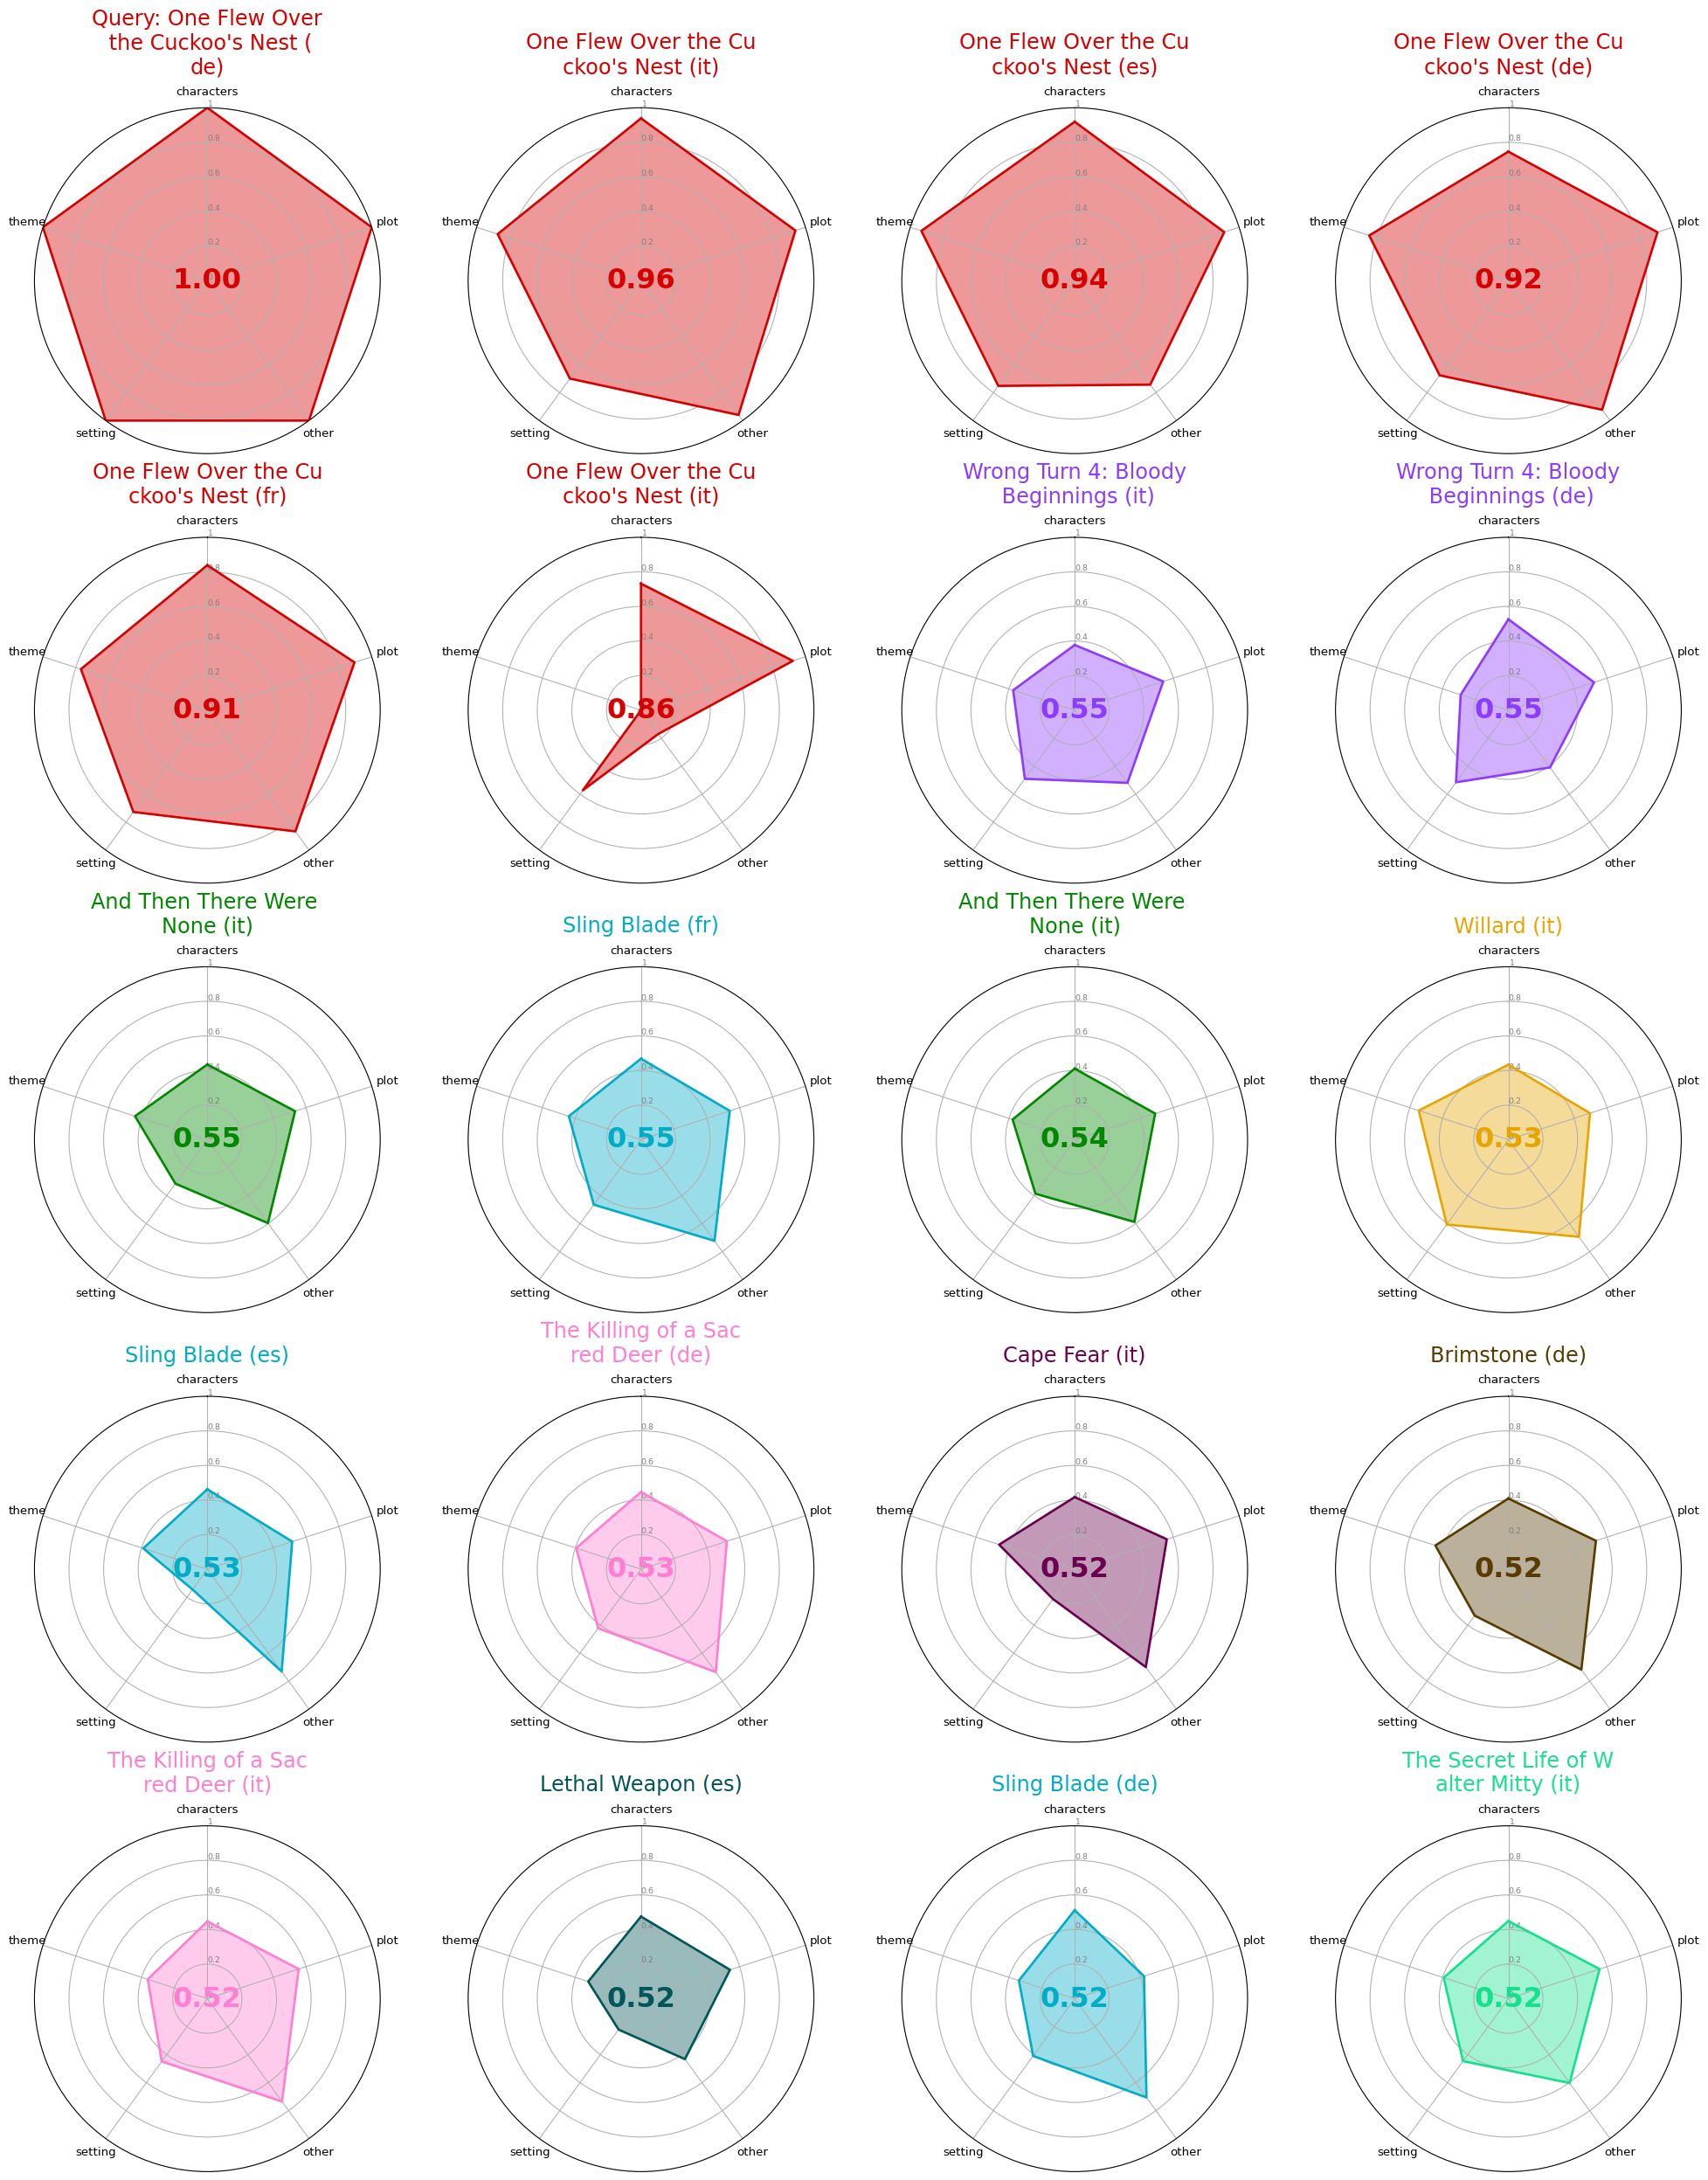

CPU times: total: 3.02 s
Wall time: 3.07 s


In [43]:
%%time
visualize_similarities(df_val, attention_model, target_index=459, top_n=19, ascending=False, exclude_self = False, exclude_keys = ['full_summary'], plots_per_row = 4)

In [41]:
df[df['title'].str.contains('Little')]

Unnamed: 0  Unnamed: 0.1 wikidata_id                      title  \
56           915           915   Q10483376          A Little Princess   
57           917           917   Q10483376          A Little Princess   
61          1012          1012    Q1048958              Stuart Little   
62          1013          1013    Q1048958              Stuart Little   
448         9845          9845    Q1199248     Little Lord Fauntleroy   
449         9848          9848    Q1199259     Little Shop of Horrors   
450         9850          9850    Q1199259     Little Shop of Horrors   
451         9851          9851    Q1199259     Little Shop of Horrors   
516        11704         11704    Q1216898          A Little Princess   
838        20322         20322     Q151695              My Little Eye   
839        20323         20323     Q151695              My Little Eye   
840        20324         20324     Q151695              My Little Eye   
1342       31492         31492     Q192073       Little Miss Sunshine   
1343       31493         31493     Q192073       Little Miss Sunshine   
1344       31494         31494     Q192073       Little Miss Sunshine   
1369       31973         31973     Q195274               Little Women   
1488       34790         34790   Q20814663  My Little Pony: The Movie   
1489       34792         34792   Q20814663  My Little Pony: The Movie   
1490       34793         34793   Q20814663  My Little Pony: The Movie   
1855       41237         41237      Q25338          The Little Prince   
1856       41238         41238      Q25338          The Little Prince   
1857       41239         41239      Q25338          The Little Prince   
1933       42931         42931     Q267866               Little Nicky   
1934       42933         42933     Q267866               Little Nicky   
1935       42934         42934     Q267866               Little Nicky   
2303       51998         51998     Q371079     Little Herr Friedemann   
2304       51999         51999     Q371079     Little Herr Friedemann   
2305       52000         52000     Q371079     Little Herr Friedemann   
2360       53370         53370     Q387480     Little Lord Fauntleroy   
2847       60594         60594    Q5241443              Stuart Little   
2983       63149         63149   Q56881140               Little Women   
2984       63150         63150   Q56881140               Little Women   
2985       63152         63152   Q56881140               Little Women   
2994       63320         63320     Q571167     Little Lord Fauntleroy   
2995       63322         63322     Q571167     Little Lord Fauntleroy   
3766       77644         77644     Q841203            Little Children   
3767       77645         77645     Q841203            Little Children   
3768       77646         77646     Q841203            Little Children   
3769       77647         77647     Q841203            Little Children   
3808       78265         78265     Q850522               Little Women   
3809       78267         78267     Q850522               Little Women   
3810       78268         78268     Q850522               Little Women   

     language                                   unpacked_summary  \
56         de  Sara Crewe is brought from India at the age of...   
57         it  Sara's father has to leave on a business trip ...   
61         fr  New York, the whole family is impressed by Stu...   
62         it  This is New York. In the Little house, a beaut...   
448        de  In the 1880s, after the death of his father, y...   
449        de  Most of the story takes place in Mr. Mushnik's...   
450        it  New York in the '60s. Seymour Krelborn works i...   
451        es  A florist named Seymour Krelborn (Rick Moranis...   
516        es  Sara Crewe (Liesel Matthews) is the kind and c...   
838        de  Five young adults (the three men Matt, Rex and...   
839        fr  Young Rex, Emma, Charlie, Matt, and Danny part...   
840        it  Five boys agree to spend six months

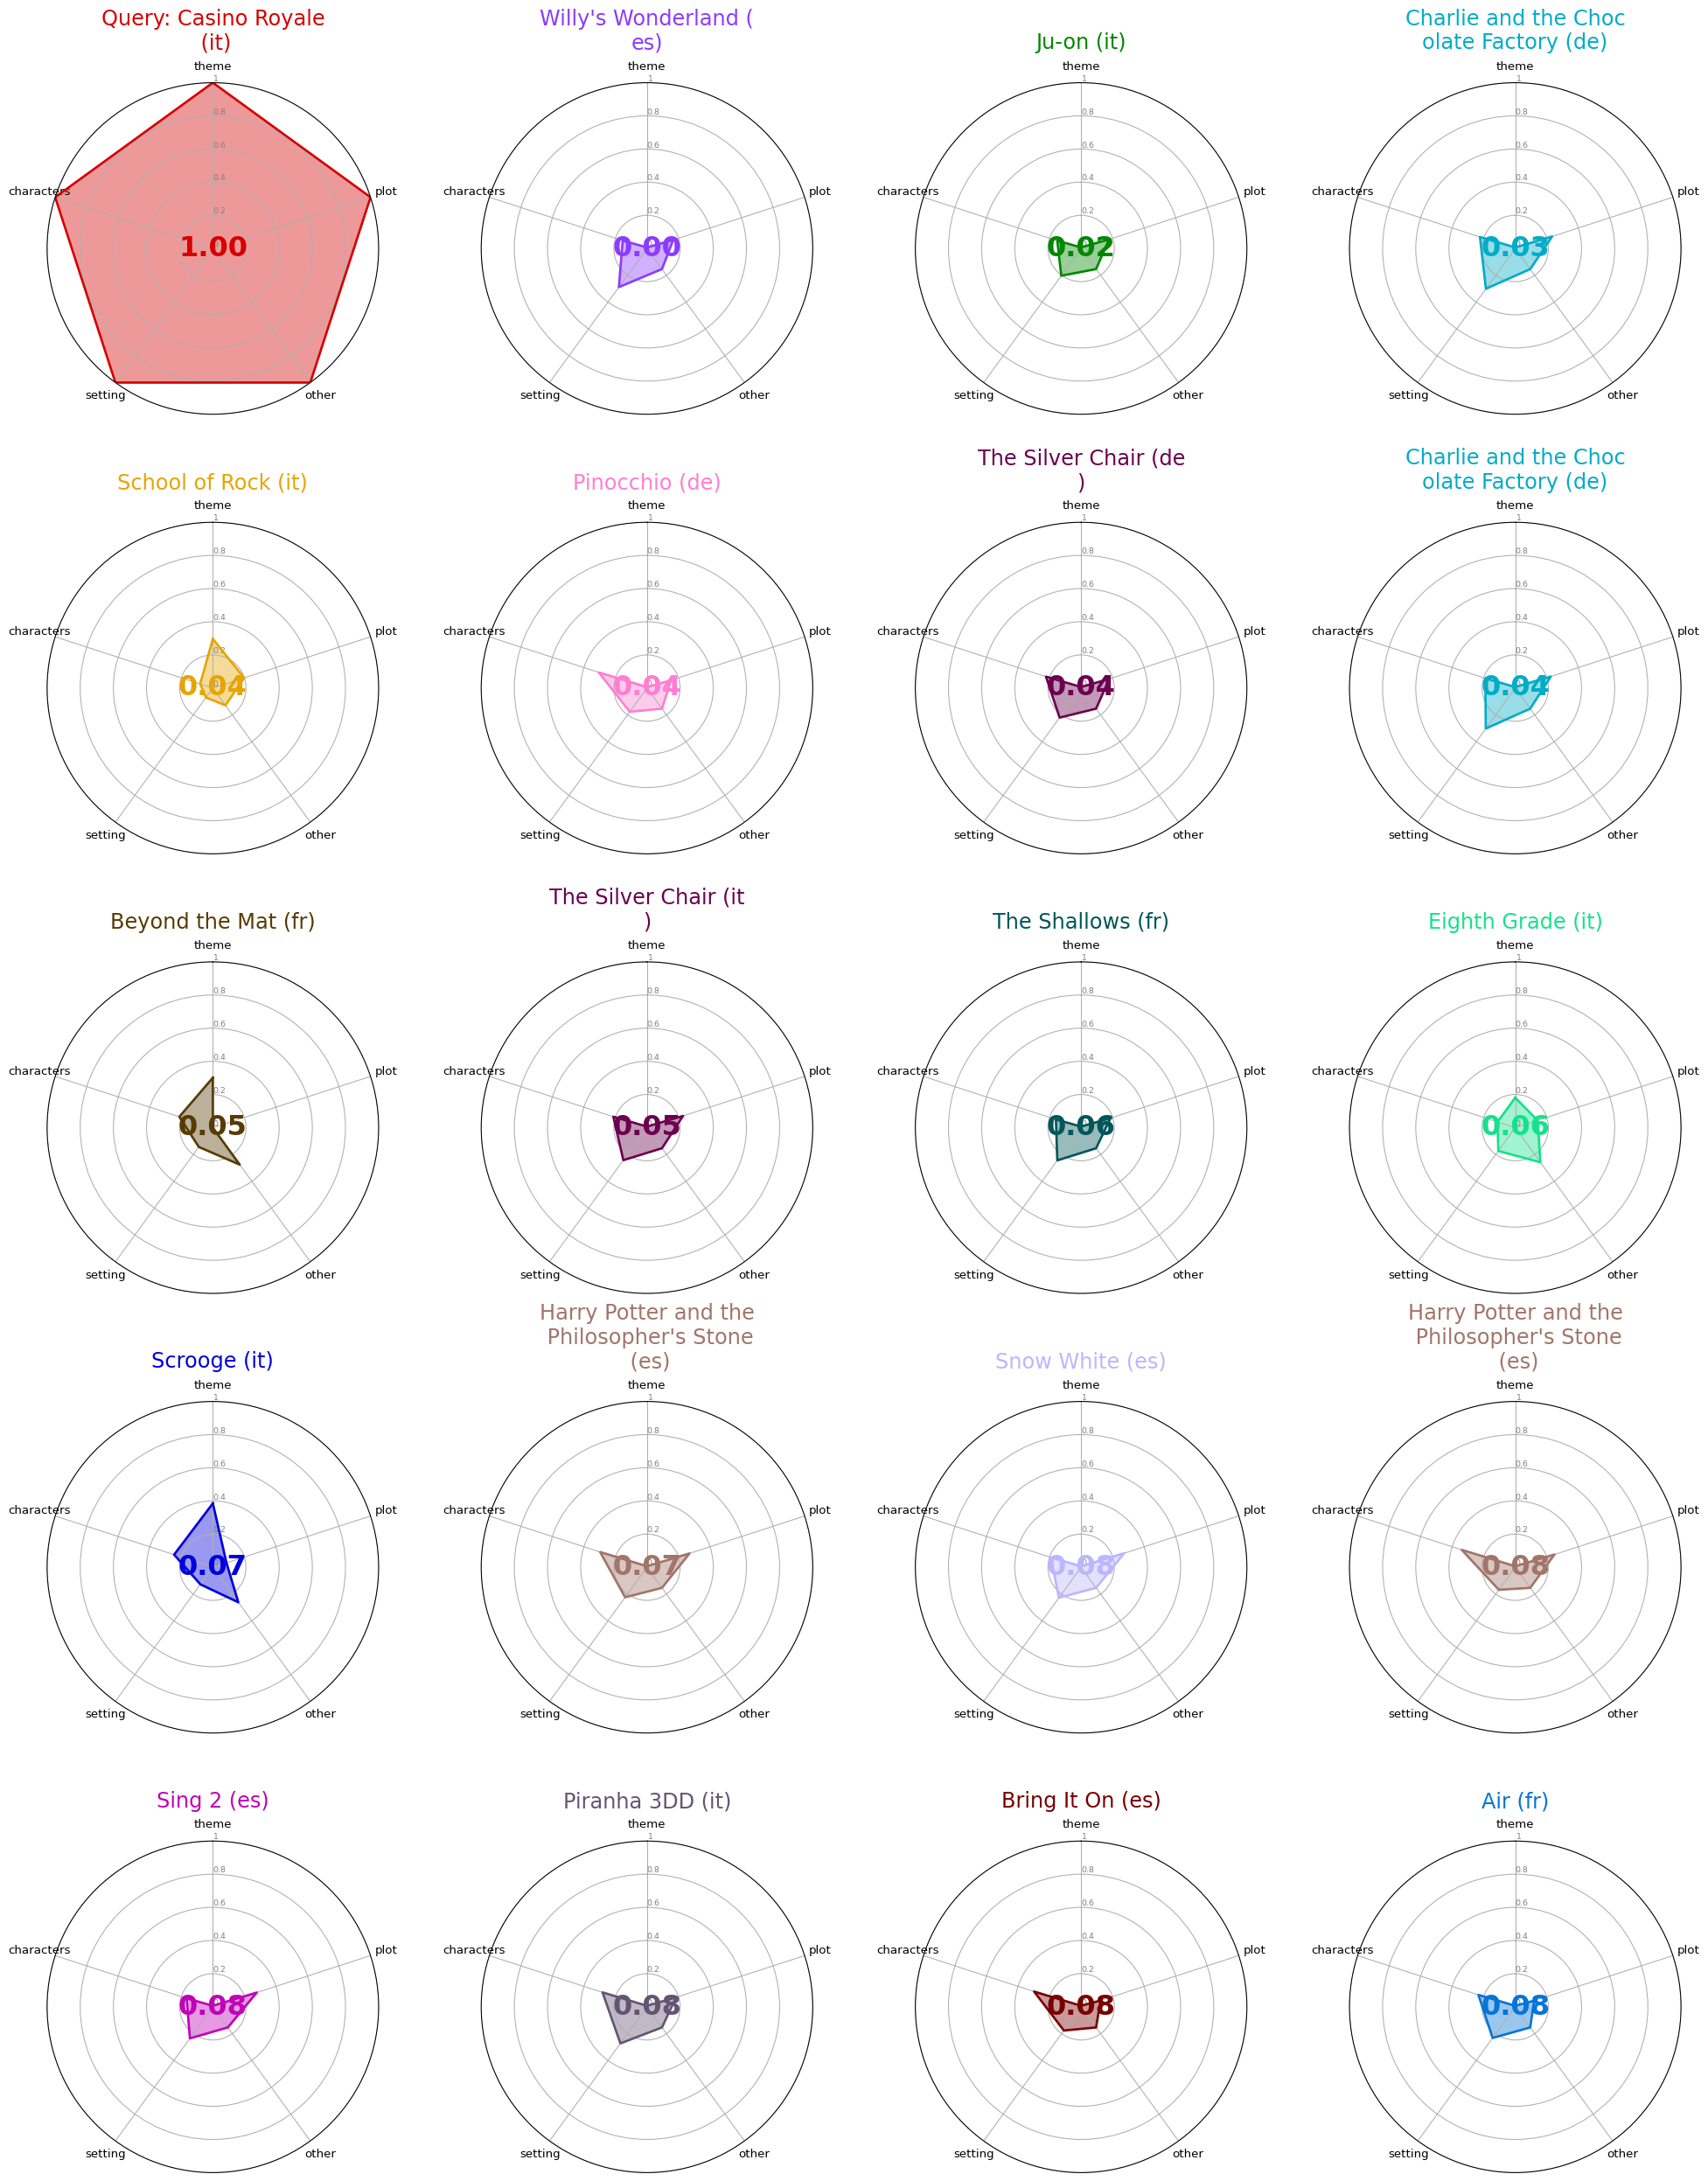

CPU times: total: 3.08 s
Wall time: 3.09 s


In [36]:
%%time
visualize_similarities(df, attention_model, target_index=54, top_n=19, ascending=True, exclude_self = True, exclude_keys = ['full_summary'], plots_per_row = 4)

In [ ]:
attention_model.print_weights = True

In [ ]:
#df,_ = embed_elements(df, model)
df = apply_attention(df, embedding_cols, attention_model)

In [ ]:
[[0.1143],
        [0.0674],
        [0.2779],
        [0.0522],
        [0.1623],
        [0.3259]

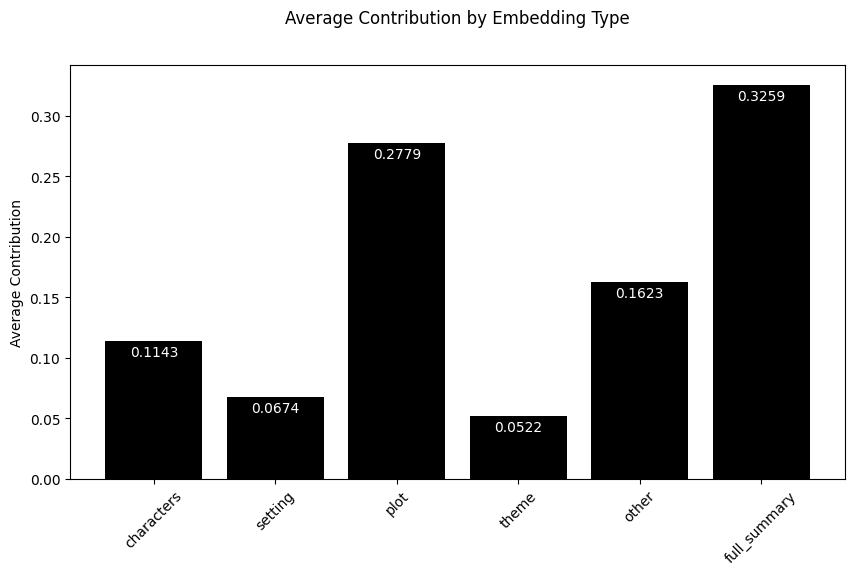

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data
contributions = np.array([0.1143, 0.0674, 0.2779, 0.0522, 0.1623, 0.3259])
categories = ["embedding_characters", "embedding_setting", "embedding_plot", 
              "embedding_theme", "embedding_other", "embedding_full_summary"]
cleaned_labels = [label.replace("embedding_", "") for label in categories]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(cleaned_labels, contributions, color='black')
plt.ylabel('Average Contribution')
plt.title('Average Contribution by Embedding Type', pad=30)  # More padding above title
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.015, f'{height:.4f}',
             ha='center', va='bottom', color = 'white')

# Manually set top margin to avoid clipping
plt.subplots_adjust(top=0.8)  # Lower value means more space at top
plt.show()
